# Anatomy of an MD simulation script File

Different simulation packages often use different languages and have different syntax. For example, HOOMD-Blue uses a Python based interface, LAMMPS uses its own custom scripting language, and GROMACS relies upon an input file to define parameters and methods.   However, despite these differences they all generally require the same information to be passed to the code 

### Basic components of most script/input files
#### system/code initialization 
>box size, particle types, particle initial positions

#### interaction definition 
>how do the different species interact with each other

#### integrator setup
>what algorithm will we use to advance particles in time, time step of integration, thermodynamic state point (i.e., T or P).

#### runtime parameters 
>total simulation time, which quantities to output and how frequently

## Basic HOOMD-Blue script file
As an example of defining each of these various components, consider setting a very simple simulation consisting of spheres that interact via the Lennard-Jones potential.  This exercise is based on the following tutorial created by HOOMD developer Josh Anderson:
http://nbviewer.jupyter.org/github/joaander/hoomd-examples/blob/master/Tutorial%20-%20MD%20-%20Lennard%20Jones.ipynb

### Initialization

HOOMD-Blue uses a Python interface, so we must first import the relevant library and functions. 

In [1]:
import hoomd
import hoomd.md

Next we must specify the 'execution context' to tell the code whether to run on the GPU and CPU.  Note, by default HOOMD-Blue will run on the GPU if a compatible one is available, unless otherwise specified via the command line options or by passing an argument to the context initializer.  

In [2]:
hoomd.context.initialize("")

HOOMD-blue 2.3.0 DOUBLE HPMC_MIXED SSE SSE2 SSE3 
Compiled: 04/25/18
Copyright 2009-2018 The Regents of the University of Michigan.
-----
You are using HOOMD-blue. Please cite the following:
* J A Anderson, C D Lorenz, and A Travesset. "General purpose molecular dynamics
  simulations fully implemented on graphics processing units", Journal of
  Computational Physics 227 (2008) 5342--5359
* J Glaser, T D Nguyen, J A Anderson, P Liu, F Spiga, J A Millan, D C Morse, and
  S C Glotzer. "Strong scaling of general-purpose molecular dynamics simulations
  on GPUs", Computer Physics Communications 192 (2015) 97--107
-----
HOOMD-blue is running on the CPU


Note, one can pass arguments to the intialize function (see [the documentation](https://hoomd-blue.readthedocs.io/en/stable/module-hoomd-context.html), to e.g., specify it to run on the CPU with a set number of threads, 
```context.initialize("--mode=cpu --nthreads=64")```

Particle positions next need to be specified.  HOOMD includes a few helper functions, primarily for the purposes of benchmarking, that allow simple systems to be defined.  Note, in most cases, you will specify particle positions in a separate file (using the [GSD](http://gsd.readthedocs.io/en/stable/) format) and import this into hoomd (see [the documentation](https://hoomd-blue.readthedocs.io/en/stable/module-hoomd-init.html).  Here we will create an 'n' by 'n' by 'n' lattice of particles, with 'n'=5. 

In [3]:
hoomd.init.create_lattice(unitcell=hoomd.lattice.sc(a=2.0), n=5)

notice(2): Group "all" created containing 125 particles


Note, by default, these particles will be labeled as type "A".

### Interaction Definition

Next we will define how particles interact.  In this case, we will consider all interactions to be of type Lennard-Jones.  In HOOMD, when defining a pair potential, we must also pass a neighborlist. Note, HOOMD-Blue supports several different types of neighborlists that will be discussed in detail later. Here, we will specify a 'cell'-based neighborlist (```nl```) and define the Lennard-Jones pair potential (```lj```), with a cutoff of 2.5. 

In [4]:
nl = hoomd.md.nlist.cell()
lj = hoomd.md.pair.lj(r_cut=2.5, nlist=nl)

Next we need to specify the pair coefficients, i.e., epsilon and sigma for the LJ interaction, for each pair of particle types in the system.  Since we only have a single type in our system ('A'), we need only define a single pair.  Note, if you fail to define the interactions, a useful error message will be provided when you try to run the simulation:

```
**ERROR**: Type pair ('A', 'A') not found in pair coeff
**ERROR**: Not all pair coefficients are set
```


In [5]:
lj.pair_coeff.set('A', 'A', epsilon=1.0, sigma=1.0)

### Integrator Setup

To actually move particles through time, we will specify the timestep of integration (i.e., our time resolution for the numerical integration):

In [6]:
hoomd.md.integrate.mode_standard(dt=0.005)

Next we specify the integration scheme and which particles it will apply to.  Note, in most codes, users do not explicitly specify the underlying algorithm for numerical integration  (e.g., Velocity-Verlet), as this is implicitly defined when selecting the larger integration scheme (i.e., selecting a thermostatting scheme).  

Below, we create a [group](https://hoomd-blue.readthedocs.io/en/stable/module-hoomd-group.html) named "all" (that includes all particles) and use the [Langevin](https://hoomd-blue.readthedocs.io/en/stable/module-md-integrate.html?highlight=langevin) method:

In [7]:
all = hoomd.group.all();
hoomd.md.integrate.langevin(group=all, kT=0.2, seed=42);

notice(2): integrate.langevin/bd is using specified gamma values


### Runtime parameters

It is not typically useful to run a simulation without logging the thermodynamic quantities and structure.   Here we  define a log file using the [analyze function](https://hoomd-blue.readthedocs.io/en/stable/module-hoomd-analyze.html) to output specific thermodynamic quantities and the frequency for outputting them:

In [8]:
hoomd.analyze.log(filename="log-output.log",
                  quantities=['potential_energy', 'temperature'],
                  period=100,
                  overwrite=True)

Similarly, we define the name and frequency for outputting a trajectory using the [dump function](https://hoomd-blue.readthedocs.io/en/stable/module-hoomd-dump.html). Note that DCD trajectories can also be written, however, GSD files contain the necessary information to restart a simulation.  

In [9]:
hoomd.dump.gsd("trajectory.gsd", period=2e3, group=all, overwrite=True)

Finally, we must specify the time period to run.  Note, in HOOMD the system will begin running as soon as the run time is defined.  A HOOMD script can have multiple calls to ```run```, as will be discussed later. 

In [10]:
hoomd.run(1e4)

notice(2): -- Neighborlist exclusion statistics -- :
notice(2): Particles with 0 exclusions             : 125
notice(2): Neighbors included by diameter          : no
notice(2): Neighbors excluded when in the same body: no
** starting run **
Time 00:00:21 | Step 10000 / 10000 | TPS 11236.5 | ETA 00:00:00
Average TPS: 11222.3
---------
-- Neighborlist stats:
324 normal updates / 100 forced updates / 0 dangerous updates
n_neigh_min: 0 / n_neigh_max: 71 / n_neigh_avg: 23.384
shortest rebuild period: 17
-- Cell list stats:
Dimension: 3, 3, 3
n_min    : 0 / n_max: 25 / n_avg: 4.62963
** run complete **


### Full script

In [11]:
import hoomd
import hoomd.md

hoomd.context.initialize("");
hoomd.init.create_lattice(unitcell=hoomd.lattice.sc(a=2.0), n=5)

nl = hoomd.md.nlist.cell();
lj = hoomd.md.pair.lj(r_cut=2.5, nlist=nl);
lj.pair_coeff.set('A', 'A', epsilon=1.0, sigma=1.0);

hoomd.md.integrate.mode_standard(dt=0.005)

all = hoomd.group.all();
hoomd.md.integrate.langevin(group=all, kT=0.2, seed=42);

hoomd.analyze.log(filename="log-output.log",
                  quantities=['potential_energy', 'temperature'],
                  period=100,
                  overwrite=True)
hoomd.dump.gsd("trajectory.gsd", period=2e3, group=all, overwrite=True)

hoomd.run(1e4)

notice(2): Group "all" created containing 125 particles
notice(2): integrate.langevin/bd is using specified gamma values
notice(2): -- Neighborlist exclusion statistics -- :
notice(2): Particles with 0 exclusions             : 125
notice(2): Neighbors included by diameter          : no
notice(2): Neighbors excluded when in the same body: no
** starting run **
Time 00:00:00 | Step 10000 / 10000 | TPS 12320.6 | ETA 00:00:00
Average TPS: 12306.8
---------
-- Neighborlist stats:
324 normal updates / 100 forced updates / 0 dangerous updates
n_neigh_min: 0 / n_neigh_max: 71 / n_neigh_avg: 23.384
shortest rebuild period: 17
-- Cell list stats:
Dimension: 3, 3, 3
n_min    : 0 / n_max: 25 / n_avg: 4.62963
** run complete **


### Examining the log
The log file generated by hoomd can be easily plotted in matplotlib by using the ```genfromtxt``` function to read in the data. Similar to matlab, individual columns can be separated using the syntax ```data[:,column_num]```where column_num would vary between 0 and 2 in this case as each line in the data file is formatted as: ```time  potential_energy temperature```.  The plot below could easily be changed to output the temperature as a function of time by changing ```data[:,1]``` to ```data[:,2]```

In [14]:
%%%bash
###output the first 10 lines of the datafile
cat log-output.log | head -n 10

timestep	potential_energy	temperature
0	-23.07128906	0
100	-25.75068684	0.1300922752
200	-49.91344274	0.2865361634
300	-83.97514498	0.3523452488
400	-109.2390021	0.3477315356
500	-120.0497766	0.3273104013
600	-136.7939437	0.2921575244
700	-163.1101678	0.3259323393
800	-182.9315213	0.2855838167


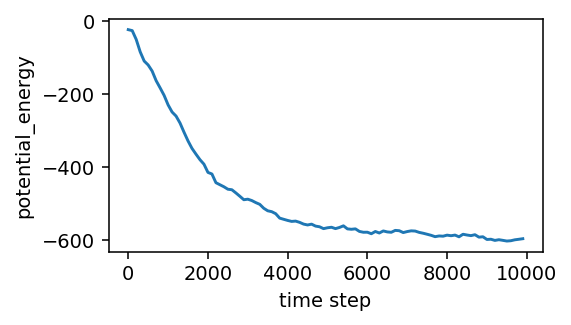

In [16]:
import numpy
from matplotlib import pyplot
%matplotlib inline
data = numpy.genfromtxt(fname='log-output.log', skip_header=True);

pyplot.figure(figsize=(4,2.2), dpi=140);
pyplot.plot(data[:,0], data[:,1]);
pyplot.xlabel('time step');
pyplot.ylabel('potential_energy');